# 4. Automatic Prediction

Use&nbsp;scikit-learn&nbsp;to&nbsp;train&nbsp;a&nbsp;classifier&nbsp;for&nbsp;the&nbsp;automatic&nbsp;prediction&nbsp;of&nbsp;the&nbsp;labels&nbsp;in&nbsp;the&nbsp;two&nbsp;datasets&nbsp;you&nbsp;have&nbsp;chosen.

- [X] Import labels, the tokenized tweets

In [ ]:
import pandas as pd
import glob
import numpy as np
from matplotlib import ticker
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,classification_report, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import plot_confusion_matrix
from nltk.stem import PorterStemmer
from sklearn import tree
import random
#import emoji
import warnings
import pickle
import seaborn as sns
from sklearn.metrics import f1_score
import collections
import sys
from nltk.stem import PorterStemmer
sys.path.insert(0, '/work/twitter-nlp')
from boilerplate import load_and_tokenize, pickling, open_jar


In [ ]:
# importing data, tokenize and pickle all the data
hate_path = "/work/twitter-nlp/data/tweeteval/datasets/hate"
emoji_path = "/work/twitter-nlp/data/tweeteval/datasets/emoji"

def tokenize_and_pickle(path, location):
    files = glob.glob(path + "/*.txt")
    for i in files:
        if i == "/work/twitter-nlp/data/tweeteval/datasets/hate/mapping.txt" or i == "/work/twitter-nlp/data/tweeteval/datasets/emoji/mapping.txt":
            pass
        else:
            if "hate" in path:
                data = load_and_tokenize(i, "Regex")
                new_path = location + "/pickled_" + i[35:-4] + ".pkl"
                # print(new_path)
                pickling(data, new_path)
            elif "emoji" in path:
                data = load_and_tokenize(i, "Regex")
                new_path = location + "/pickled_" + i[36:-4] + ".pkl"
                # print(new_path)
                pickling(data, new_path)
            
# tokenize_and_pickle(hate_path, location="/work/twitter-nlp/data/pickle/tweeteval/hate")
# tokenize_and_pickle(emoji_path, location="/work/twitter-nlp/data/pickle/tweeteval/emoji")

- [X] Split data into train - test, make stratified test-val iterable

In [ ]:
# hatespeech splitting of train and test groups
train_txt = open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_train_text.pkl')
train_labels = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_train_labels.pkl'))
val_txt = open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_val_text.pkl')
val_labels = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_val_labels.pkl'))
X_train_txt = train_txt.copy()
X_train_txt.extend(val_txt)
y_train = pd.concat([train_labels,val_labels], ignore_index=True)
print(y_train.shape)

(10000, 1)


In [ ]:
#pickling(X_train_txt,'/work/twitter-nlp/data/tweeteval/datasets/hate/final_x_train_txt.pkl')
#open_jar('/work/twitter-nlp/data/tweeteval/datasets/hate/final_x_train_txt.pkl')
#pickling(y_train,'/work/twitter-nlp/data/tweeteval/datasets/hate/final_y_train_txt.pkl')
#open_jar('/work/twitter-nlp/data/tweeteval/datasets/hate/final_y_train_txt.pkl')

In [ ]:
# emoji splitting of train and test groups
train_txt_emoji = open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_train_text.pkl')
train_labels_emoji = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_train_labels.pkl'))
val_txt_emoji = open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_val_text.pkl')
val_labels_emoji = pd.DataFrame(open_jar('/work/twitter-nlp/data/pickle/tweeteval/emoji/pickled_val_labels.pkl'))
X_train_txt_emoji = train_txt_emoji.copy()
X_train_txt_emoji.extend(val_txt_emoji)
y_train_emoji = pd.concat([train_labels_emoji,val_labels_emoji], ignore_index=True).astype(int)
print(y_train_emoji.shape)
emoji_classes= pd.read_csv("/work/twitter-nlp/data/tweeteval/datasets/emoji/mapping.txt", sep = "	", header=None)

(50000, 1)


In [ ]:
def unpack_tokens(data):
    corpus_unpacked = []
    for line in data:
        corpus_unpacked.extend(word for word in line)
    lowercase_transition = (map(lambda x: x.lower(), corpus_unpacked))
    return list(lowercase_transition)

In [ ]:
def get_vocabulary_size(train):
    ps = PorterStemmer()
    unpacked_tokens = unpack_tokens(train)
    stemmed_tokens = []

    for i in unpacked_tokens:
        stemmed_tokens.append(ps.stem(i))

    return len(stemmed_tokens)

vocabulary_size_hate = get_vocabulary_size(X_train_txt)
vocabulary_size_emoji = get_vocabulary_size(X_train_txt_emoji)

In [ ]:
vocabulary_size_emoji

570452

In [ ]:
# porter stemming the x_train_txt of the hatespeech dataset

def porter_stem():
    ps = PorterStemmer()
    outer = []

    for i in X_train_txt:
        inner = []
        for x in i:
            inner.append(ps.stem(x))
        outer.append(inner)
    return outer

X_train_stemmed = porter_stem()

- [X] Run all classification experiments on both of the tasks you’ve chosen (one binary and one multi-class task). 

## Hatespeech Model Training:

In [ ]:
# list_of_classifiers_hate = []
# l_o_classifiers = ['KNN','SGDC','MultinomialNB','DTC','RF']

In [ ]:
warnings.filterwarnings('ignore')
def classify_hate(model, vocabulary_size, X_train_txt, y_train, confusion_matrix = False, tree1 = False, save_model=False, loss = 'log', alpha=0.0001):
    is_partial = False
    cv = CountVectorizer(max_features = vocabulary_size)
    train = [' '.join(x) for x in X_train_txt]
    X = cv.fit_transform(train).toarray()
    y = list(y_train[0])

    if model == 'KNN':
        classifier = KNeighborsClassifier(n_neighbors = 5)
    elif model == "SGDC":
        classifier = SGDClassifier(loss=loss, alpha = alpha)
        is_partial = True
    elif model == "MultinomialNB":
        classifier = MultinomialNB()
        is_partial = True
    elif model == "DTC":
        classifier = DecisionTreeClassifier()
    elif model == "RF":
        classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state = 0)
    if is_partial:
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        sss.get_n_splits(X, y_train)
        y_train_1 = y_train.copy().to_numpy().astype(int)
        i = 0
        for train_index, test_index in sss.split(X, y_train_1):
            X_train_s, X_val_s = X[train_index], X[test_index]
            y_train_s, y_val_s= y_train_1[train_index], y_train_1[test_index]
            if i==0:
                classifier.partial_fit(X_train_s, y_train_s, classes = [0,1])
            else:
                classifier.partial_fit(X_train_s, y_train_s)
        X_test,y_test = X_val_s,y_val_s
        pred = classifier.predict(X_val_s)
        acc_score = accuracy_score(y_test, pred)
        f1score = f1_score(y_val_s, pred)
        recallscore = recall_score(y_test, pred)
        precscore = precision_score(y_test, pred)
    else:               
        X_train, X_test, y_train_1, y_test = train_test_split(
                X, y, test_size = 0.25, random_state = 0)
        classifier.fit(X_train, y_train_1)
        pred = classifier.predict(X_test)
        acc_score = accuracy_score(y_test, pred)
        f1score = f1_score(y_test, pred, pos_label='0')
        recallscore = recall_score(y_test, pred, pos_label='0')
        precscore = precision_score(y_test, pred, pos_label='0')
    if confusion_matrix == True:
        plot_confusion_matrix(classifier, X_test, y_test)
    if tree1 == True:
        # print("Plotting Decision Tree...")
        text_representation = tree.export_text(classifier, feature_names = list(cv.get_feature_names_out()))
        # print(text_representation)
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(classifier, feature_names = list(cv.get_feature_names_out()), class_names=['non-hatespeech', 'hatespeech'])
        plt.savefig("tree.svg", format="svg")

    if save_model == True:
        filename = '/work/twitter-nlp/data/pickle/models/hatespeech_model_RF.sav'
        pickling(classifier,filename)
        # list_of_classifiers_hate.append(classifier)

    return f1score, acc_score, recallscore, precscore


In [ ]:
classify_hate('RF', vocabulary_size_hate, X_train_txt, y_train, confusion_matrix = False, save_model=True)

(0.8114359139094122, 0.7652, 0.8856942496493688, 0.7486662714878483)

To better understand the results, we show the ratio of hatespeech, and not hatespeech below. <br/>

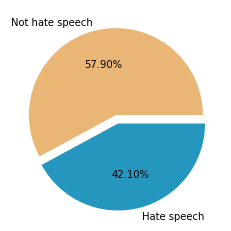

In [ ]:
plt.rcParams['font.size'] = 11.0
plt.pie(collections.Counter(list(y_train[0])).values(), labels=['Not hate speech','Hate speech'],colors=['#eab676','#2596be'],explode=(0, 0.1), autopct = lambda p:f'{p:.2f}%');

Based on this we deduced that our results were acceptable. 

In [ ]:
# for evaluating each model 

def eval_models():
    models = ["KNN", "SGDC", 'MultinomialNB','DTC', 'RF']
    li = {}
    for model in models:
        li.setdefault(model, classify_hate(model, vocabulary_size_hate, X_train_txt, y_train))
    return li

# Hate speech functions

Testing different types of loss for the SGDC classifier on the hatespeech dataset

In [ ]:
def test_losses():
    losses = ['hinge','modified_huber','log','squared_hinge','perceptron','squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive']
    scores = {s:0 for s in losses}
    for _ in range(10):
        for loss in losses:
            print(loss)
            scores[loss]+=float(classify_hate('SGDC',loss=loss)[0])/10
    return scores

# test_losses()
open_jar('/work/twitter-nlp/data/pickle/models/hate/loss_scores.pkl')

{'hinge': 0.7349062239347153,
 'modified_huber': 0.7355510840948916,
 'log': 0.7611404875154572,
 'squared_hinge': 0.7372772172334918,
 'perceptron': 0.7200106374683496,
 'squared_error': 0.4324811728108835,
 'huber': 0.7106919452830548,
 'epsilon_insensitive': 0.502026632077352,
 'squared_epsilon_insensitive': 0.42780788875914944}

Testing impact of parameter alpha on the overall performance of the SGDC classifier:

In [ ]:
def alpha_sgdc_test():
    alpha_scores = {max([0.0001 * s * s,0.0001]):0 for s in range(0,100,10)}

    for _ in range(10):
        for i in range(0,100,10):
            coef = max([0.0001 * i * i,0.0001]) 
            alpha_scores[coef] += float(classify_hate(
                'SGDC',
                vocabulary_size_hate, 
                X_train_txt, 
                y_train, 
                loss='log', 
                alpha = coef
                )[0])/10
    
    pickling(alpha_scores,'/work/twitter-nlp/data/pickle/models/hate/alpha_scores.pkl')
        
# alpha_sgdc_test()

In [ ]:
alpha_scores = open_jar('/work/twitter-nlp/data/pickle/models/hate/alpha_scores.pkl')
# alpha_scores

Printing final alpha scores TODO

In [ ]:
multi=classify_hate("MultinomialNB", vocabulary_size_hate, X_train_txt, y_train)

In [ ]:
sgd=classify_hate("SGDC", vocabulary_size_hate, X_train_txt, y_train)

In [ ]:
knn=classify_hate("KNN", vocabulary_size_hate, X_train_txt, y_train)

In [ ]:
dtc=classify_hate('DTC', vocabulary_size_hate, X_train_txt, y_train)

In [ ]:
rf=classify_hate('RF', vocabulary_size_hate, X_train_txt, y_train)

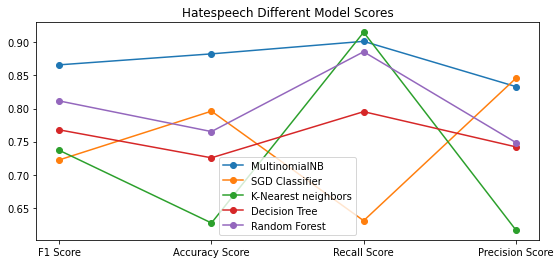

In [ ]:
fig, axes = plt.subplots(figsize=(9, 4))
x = [1,2,3,4]
axes.plot(x,multi,label='MultinomialNB', marker='o')
axes.plot(x,sgd,label='SGD Classifier', marker='o')
axes.plot(x,knn,label='K-Nearest neighbors', marker='o')
axes.plot(x,dtc,label='Decision Tree', marker='o')
axes.plot(x,rf,label='Random Forest', marker='o')
axes.set_xticks([1,2,3,4])
axes.set_xticklabels(["F1 Score", "Accuracy Score", "Recall Score", "Precision Score"]), 
axes.set_title("Hatespeech Different Model Scores")
axes.legend();

## Emoji Prediction Model Training:

In [ ]:
five_split_txt_emoji = np.array_split(X_train_txt_emoji, 5)
len(five_split_txt_emoji[0])

10000

In [ ]:
five_split_labels_emoji = np.array_split(y_train_emoji,5)
len(five_split_labels_emoji[0])

10000

Showing ratio of labels in our emoji dataset:

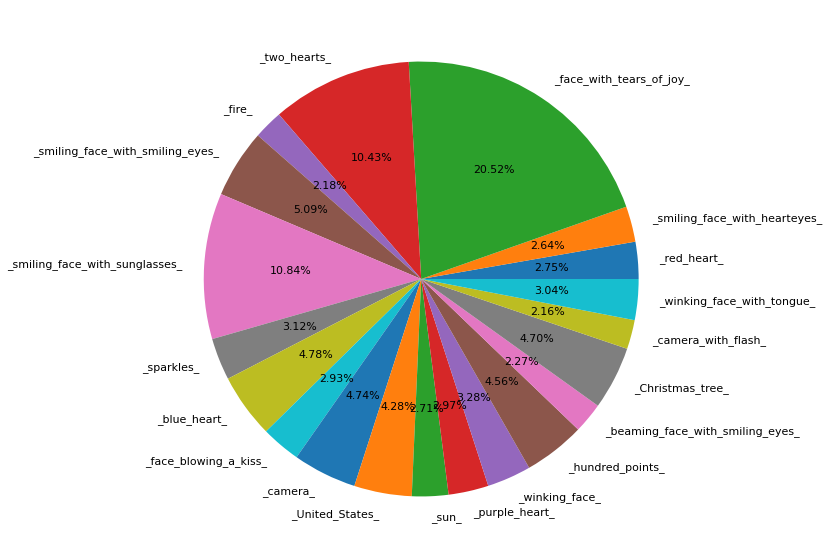

In [ ]:
plt.rcParams['font.size'] = 11.0
plt.figure(figsize=(10, 10))
plt.pie(collections.Counter(list(y_train_emoji[0])).values(), labels=list(emoji_classes[2]), autopct = lambda p:f'{p:.2f}%');


Training based on different models, all in one function, and plotting confusion matrix.

- [x] Evaluate your different classifiers on the validation set and report relevant evaluation metrics (accuracy, precision/recall/F-score).

(see above for hatespeech scores)

In [ ]:
#helper function to classify emojis, using the stratified shuffle split
def partial_fitting_emoji(classifier):
    global y_train_emoji
    cv = CountVectorizer(max_features = 570452)
    # X_train_emoji = cv.fit_transform([' '.join(s) for s in X_train_txt_emoji]).toarray()
    i = 0
    for X, y in zip(five_split_txt_emoji,five_split_labels_emoji):
        X_train_emoji = cv.fit_transform([' '.join(s) for s in X])
        X_train, X_test, y_train, y_test = train_test_split(X_train_emoji, y, test_size = 0.25, random_state = 0)
       # print(f'X_train {X_train}, X_test {X_test}, y_train {y_train}, y_test {y_test}')
        a = list(np.unique(y_test))
        a.sort()
        #print(f'y_test:\n {a}\n\n')
        if i==0:
            classifier.partial_fit(X_train, y_train, classes = list(emoji_classes[0]))#Get classes for emoji
        else:
            classifier.partial_fit(X_train, y_train)
    
        pred = classifier.predict(X_test)

        scores = accuracy_score(y_test, pred)
        i += 1
    return scores, X_test, y_test, pred

In [ ]:
warnings.filterwarnings('ignore')

def classify_emoji(model, confusion_matrix = False, tree1 = False, save_model = False, loss='log', alpha = 0.0001):
    is_partial = False
    global y_train
    if model == 'KNN':
        classifier = KNeighborsClassifier(n_neighbors = 5)
    elif model == "SGDC":
        classifier = SGDClassifier(loss=loss, alpha=alpha)
        is_partial = True
    elif model == "MultinomialNB":
        classifier = MultinomialNB()
        is_partial = True
    elif model == "DTC":
        classifier = DecisionTreeClassifier()
    elif model == 'GaussianNB':
        classifier = GaussianNB()
        is_partial = True
    if is_partial:
        acc_score, X_test,y_test, pred =  partial_fitting_emoji(classifier)
        f1score = f1_score(y_test, pred, average='weighted')
        recallscore = recall_score(y_test, pred, average='weighted')
        precscore = precision_score(y_test, pred, average='weighted')
    else:
        cv = CountVectorizer(max_features = 570452)
        scores = []
        X, y = X_train_txt_emoji, y_train_emoji
        X_train_emoji = cv.fit_transform([' '.join(s) for s in X])
        X_train, X_test, y_train, y_test = train_test_split(X_train_emoji, y, test_size = 0.25, random_state = 0)
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        f1score = f1_score(y_test,pred, average='weighted')
        acc_score = accuracy_score(y_test, pred)
        scores.append(acc_score)
        recallscore = recall_score(y_test, pred, average='weighted')
        precscore = precision_score(y_test, pred, average='weighted')
    if confusion_matrix == True:
        _, ax = plt.subplots(figsize=(10,10))
        plot_confusion_matrix(classifier, X_test, y_test, ax = ax)
    if tree1 == True:
        print("Plotting Decision Tree...")
        text_representation = tree.export_text(classifier, feature_names = list(cv.get_feature_names_out()))
        print(text_representation)
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(classifier, feature_names = list(cv.get_feature_names_out()), class_names=emoji_classes[1])
        plt.savefig("tree.svg", format="svg")

    if save_model == True:
        filename = '/work/twitter-nlp/data/pickle/models/emoji_model.sav'
        pickling(classifier,filename)

    return f1score,acc_score, recallscore, precscore
    
classify_emoji("MultinomialNB", confusion_matrix = True)

ValueError: X has 18985 features, but MultinomialNB is expecting 19367 features as input.

In [ ]:
def eval_emoji_models():
    models = ["KNN", "SGDC", 'MultinomialNB','DTC', 'GaussianNB']
    li = {}

    for model in models:
        acc_score, X_test,pred, f1score = classify_emoji("SGDC")
        li.setdefault(model, [acc_score, f1score])
    return li

In [ ]:
li = eval_emoji_models()
li

{'KNN': [0.19878965623641023, 0.1959950276812557],
 'SGDC': [0.21231669157530514, 0.21095687128928212],
 'MultinomialNB': [0.2063976896945369, 0.2116806931025284],
 'DTC': [0.21400899224813533, 0.20394450802013775],
 'GaussianNB': [0.20577058400227297, 0.19730599471635374]}

In [ ]:
def test_losses_emoji():
    losses = ['hinge','modified_huber','log','squared_hinge','perceptron','squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive']
    scores = {s:0 for s in losses}
    for _ in range(10):
        for loss in losses:
            scores[loss]+=float(classify_emoji('SGDC',loss=loss)[1])/10
    return scores

# scores = test_losses_emoji()
# pickling(scores, '/work/twitter-nlp/data/pickle/models/emoji/log_scores.pkl')

In [ ]:
open_jar('/work/twitter-nlp/data/pickle/models/emoji/log_scores.pkl')

{'hinge': 0.2046,
 'modified_huber': 0.18683999999999998,
 'log': 0.23804,
 'squared_hinge': 0.17944000000000002,
 'perceptron': 0.1884,
 'squared_error': 0.05008,
 'huber': 0.16172000000000003,
 'epsilon_insensitive': 0.07924,
 'squared_epsilon_insensitive': 0.04632}

In [ ]:
def alpha_sgdc_test_emoji():
    alpha_scores = {max([0.0001 * s * s,0.0001]):0 for s in range(0,100,10)}

    for _ in range(10):
        for i in range(0,100,10):
            coef = max([0.0001 * i * i,0.0001]) 
            alpha_scores[coef]+=float(classify_emoji('SGDC', loss='log', alpha = coef)[1])/10
    return alpha_scores

# alpha_scores = alpha_sgdc_test_emoji()
# pickling(alpha_scores,'/work/twitter-nlp/data/pickle/models/emoji/alpha_scores.pkl')

- [x] For the systems that achieves the highest accuracy on the validation set, run the evaluation on the test set and report your results.

In [ ]:
def classify_sentence(text):
    classifier = open_jar('/work/twitter-nlp/data/pickle/models/hatespeech_model_MultinomialNB2.sav')
    cv = open_jar('/work/twitter-nlp/data/pickle/models/hate/vectorizer.pkl')
    return classifier.predict_proba(cv.transform([text]).toarray())

def predict_list(df_column):
    predict_list = []
    for i in df_column:
        line_data = classify_sentence([str(i)])
        predict_list.append(line_data.tolist())
    return predict_list

x_test_txt = open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_test_text.pkl')

results = predict_list(x_test_txt)

In [ ]:
saved_models_hate = ['DTC','KNN','SGDC','MultinomialNB2','RF']
results = []
cv = open_jar('/work/twitter-nlp/data/pickle/models/hate/vectorizer.pkl')
X_test = open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_test_text.pkl')
X_test = cv.transform([' '.join(s) for s in X_test])
y_test = pd.DataFrame([s[0] for s in open_jar('/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_test_labels.pkl')]).astype(int)
for model in saved_models_hate:
        classifier = open_jar(f'/work/twitter-nlp/data/pickle/models/hatespeech_model_{model}.sav')
        pred = pd.DataFrame(classifier.predict(X_test)).astype(int)
        acc_score = accuracy_score(y_test, pred)
        f1score = f1_score(y_test, pred,pos_label=0)
        recallscore = recall_score(y_test, pred,pos_label=0)
        precscore = precision_score(y_test, pred,pos_label=0)
        results.append((model,(acc_score,f1score,recallscore,precscore)))

results

{0} <class 'pandas.core.series.Series'> {0} <class 'pandas.core.series.Series'>
{0} <class 'pandas.core.series.Series'> {0} <class 'pandas.core.series.Series'>
{0} <class 'pandas.core.series.Series'> {0} <class 'pandas.core.series.Series'>
{0} <class 'pandas.core.series.Series'> {0} <class 'pandas.core.series.Series'>
{0} <class 'pandas.core.series.Series'> {0} <class 'pandas.core.series.Series'>


[('DTC',
  (0.4632996632996633,
   0.2921847246891652,
   0.19150174621653085,
   0.6161048689138576)),
 ('KNN',
  (0.5154882154882154,
   0.3910283537875582,
   0.2689173457508731,
   0.7162790697674418)),
 ('SGDC',
  (0.5292929292929293,
   0.45813953488372094,
   0.3440046565774156,
   0.685614849187935)),
 ('MultinomialNB2',
  (0.4754208754208754,
   0.2317554240631164,
   0.13678696158323633,
   0.7580645161290323)),
 ('RF',
  (0.47003367003367,
   0.24326923076923074,
   0.14726426076833526,
   0.6988950276243094))]

In [ ]:
def label_predictions(data):
    results = []
    for i in data:
        for j in i:
            if j[1] > j[0]:
                results.append(1)
            else:
                results.append(0)
    return results

labeled_data = label_predictions(results)

In [ ]:
import itertools
y_truth = open_jar("/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_test_labels.pkl")
y_truth = list(itertools.chain(*y_truth))
# labeled_data[0]

In [ ]:
y_truth = open_jar("/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_test_labels.pkl")
agreements = []

for i in range(len(labeled_data)):
    # print(labeled_data[i], y_truth[i])
    if labeled_data[i] == 1 and y_truth[i] == ['1']:
        agreements.append("Both Agree")
    elif labeled_data[i] == 0 and y_truth[i] == ['0']:
        agreements.append("Both Agree")
    elif labeled_data[i] == 1 and y_truth[i] == ['0']:
        agreements.append("False Positive")
    elif labeled_data[i] == 0 and y_truth[i] == ['1']:
        agreements.append("False Negative")

<AxesSubplot:ylabel='Count'>

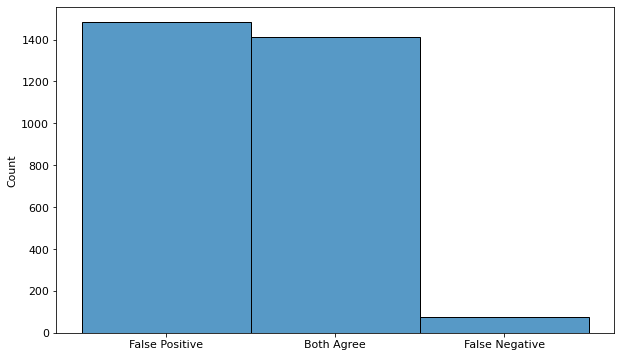

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(agreements)

In [ ]:
y_test_1 = open_jar("/work/twitter-nlp/data/pickle/tweeteval/hate/pickled_test_labels.pkl")
y_test = [item for sublist in y_test_1 for item in sublist]

In [ ]:
labeled_data = label_predictions(results)
x = [int(x) == int(y) for (x, y) in zip(labeled_data, y_test)]

In [ ]:
y = sum(x)
y/len(labeled_data)

0.4754208754208754

- [x] Then run additional experiments trying to improve your initial scores by any means you can think of. Try out at least 4 different methods.

Additional preprocessing options:
- [x] n-gram features, lowercasing, stop word lists (see options to `sklearn.feature_extraction.text.CountVectorizer)`
- [ ] `Counttransformations(sklearn.feature_extraction.text.TfIdfTransformer)`
- [x] `Theclassificationloss(lossparametertoSGDClassifier)`
- [x] The regularisation strength (alpha parameter to `SGDClassifier` – try varying it in exponentially spaced steps)
- [x] Different classifiers (e.g.,`sklearn.ensemble.RandomForestClassifieror sklearn.naive_bayes.MultinomialNB`)
- [x] Anything else discussed during the lessons, or implemented in scikit-learn.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf1f20fb-a6c0-4ea2-8567-a5a41eea1d8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>